### Outline
In this notebook, I am going to try to implement Transition State Theory (TST) to calculate the Self-Diffusion Coefficient of Xe and Kr in Ni(PyC)2 and Ni(PyC-m-NH2)2.

Helpful references include:
   1. [J. Phys. Chem. C 2016, 120, 2, 1110–1120](https://doi.org/10.1021/acs.jpcc.5b11111)
   2. [J. Chem. Phys. 122, 224712 (2005)](https://doi.org/10.1063/1.1924548)
   
Strategy:
   1. Load crystal, molecules, forcefield 
   2. perform `energy_grid()` calculation on each scructure for each adsorbate
   3. define the reaction coordinate (not sure how to do this yet)
       a) find the location of the minimum energy
       b) find the location of the minimum energy in an adjacent pocket (something about the flood-fill algorithm being used here that is implemented in `PorousMaterials.jl`).
       c) check that it is parallel to one of the crystal axes. If not, can we just define it to be that way?
       d) define a vector that connects the two points -> this will define the 1D raction coordinate
   4. take "slices" of the energy profile along the reaction coordinate
   5. perform integration using julia package [Cubature.jl](https://github.com/JuliaMath/Cubature.jl)

In [1]:
using PorousMaterials
using PyPlot
using Cubature

┌ Warning: Error requiring `OffsetArrays` from `ArrayInterface`
│   exception = (UndefVarError(:IdOffsetRange), Union{Ptr{Nothing}, Base.InterpreterIP}[Ptr{Nothing} @0x00007f671f00acef, Ptr{Nothing} @0x00007f671f09dd24, Ptr{Nothing} @0x00007f6710e28da2, Ptr{Nothing} @0x00007f671f080769, Ptr{Nothing} @0x00007f671f09cf15, Ptr{Nothing} @0x00007f671f09cbce, Ptr{Nothing} @0x00007f671f09d811, Ptr{Nothing} @0x00007f671f09e297, Base.InterpreterIP in top-level CodeInfo for ArrayInterface at statement 11, Ptr{Nothing} @0x00007f671f0b9b31, Ptr{Nothing} @0x00007f671f0bb949, Ptr{Nothing} @0x00007f66c7d542b1, Ptr{Nothing} @0x00007f66c7d542dc, Ptr{Nothing} @0x00007f671f080769, Ptr{Nothing} @0x00007f671f09cf15, Ptr{Nothing} @0x00007f671f09cbce, Ptr{Nothing} @0x00007f671f09d811, Ptr{Nothing} @0x00007f671f09db90, Ptr{Nothing} @0x00007f671f09e04a, Base.InterpreterIP in MethodInstance for err(::Any, ::Module, ::String) at statement 2, Ptr{Nothing} @0x00007f66c7d54227, Ptr{Nothing} @0x00007f66c7d5423c, Ptr

In [2]:
nipyc = Crystal("NiPyC2_experiment.cif") # Crystal("Pn_Ni-PyC-NH2.cif")

reps = (2, 1, 1) #(2, 2, 2)
xtal = replicate(nipyc, reps)

adsorbates = [Molecule("Xe"), Molecule("Kr")]
ljff = LJForceField("UFF");

┌ Info: Crystal NiPyC2_experiment.cif has Pn space group. I am converting it to P1 symmetry.
│         To prevent this, pass `convert_to_p1=false` to the `Crystal` constructor.
└ @ Xtals /home/ng/.julia/packages/Xtals/DSCSR/src/crystal.jl:433


In [3]:
# grid.box      # Bravais lattice over which a grid of points is superimposed
# grid.data     # 3 dim array containing data for each point
# grid.n_pts    # number of grid points in x, y, z
# grid.origin   # the origin of the grid
# grid.units    # units associated with each data point
res  = 0.25 # maximum distance between grid points, in Å,
grid = energy_grid(xtal, adsorbates[1], ljff, resolution=res, units=:kJ_mol) 

# get estimate for location of energy minimum on a grid to use as initial estimate 
grd_min_mol, grd_min_E = find_energy_minimum_gridsearch(xtal, adsorbates[1], ljff, resolution=res)
# find location of the energy minimum 
# this will be used as the origin of the vector describing the reaction coordinate
minimized_molecule, minimum_E = find_energy_minimum(xtal, grd_min_mol, ljff)

Computing energy grid of Xe in NiPyC2_experiment.cif
	Regular grid (in fractional space) of 52 by 52 by 43 points superimposed over the unit cell.
Computing energy grid of Xe in NiPyC2_experiment.cif
	Regular grid (in fractional space) of 52 by 52 by 43 points superimposed over the unit cell.


(Molecule species: Xe
Center of mass (fractional coords): Frac([0.7296096468340975; 0.28610120323808597; 0.8545075915153179])
Atoms:

	atom = Xe, xf = [0.730, 0.286, 0.855], -31.60183804403344)

In [4]:
# write XYZ files to aid visualization
# write xtal
write_xyz(xtal)
# write adsorbate
file_name = joinpath(pwd(), "Xe_at_Emin_in_NiPyC")
write_xyz([minimized_molecule], xtal.box, file_name)

In [5]:
# get the voxel ID for the location of the energy minimum
xf = [minimized_molecule.com.xf[i] for i in 1:3]
vox_id = xf_to_id(grid.n_pts, xf)

3-element Vector{Int64}:
 38
 15
 37

In [6]:
maximum(grid.data[:, vox_id[2], vox_id[3]])

21.78196167458534

In [7]:
minimum(grid.data[:, vox_id[2], vox_id[3]])

-31.48837152047544

## Plots

Plot the energy along a given crystal axis.

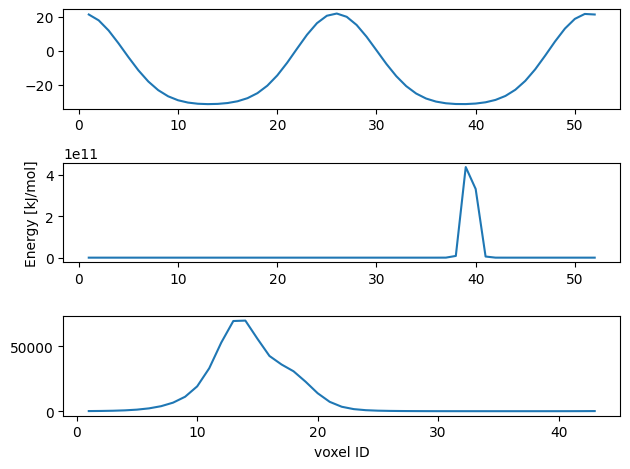

In [8]:
fig, axs = subplots(3)

x = [i for i in 1:grid.n_pts[1]]
y = [i for i in 1:grid.n_pts[2]]
z = [i for i in 1:grid.n_pts[3]]

# plot along x-axis
axs[1].plot(x, grid.data[:, vox_id[2], vox_id[3]])

# plot along y-axis
axs[2].plot(y, grid.data[vox_id[1], :, vox_id[3]])
axs[2].set_ylabel("Energy [kJ/mol]")
# axs[2].set_ylim(ymax=5000)

# plot along z-axis
axs[3].plot(z, grid.data[vox_id[1], vox_id[2], :]) # max ~70000

axs[3].set_xlabel("voxel ID")


tight_layout()

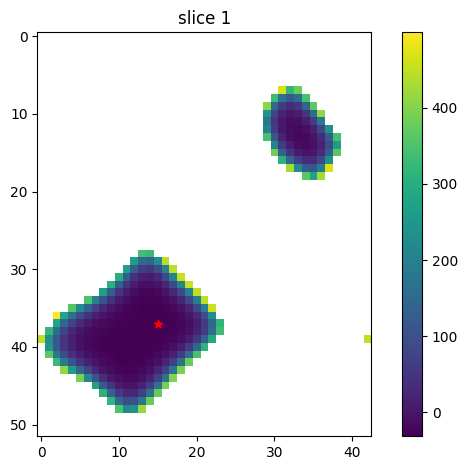

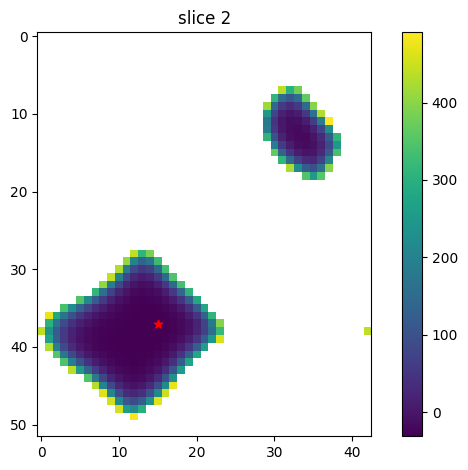

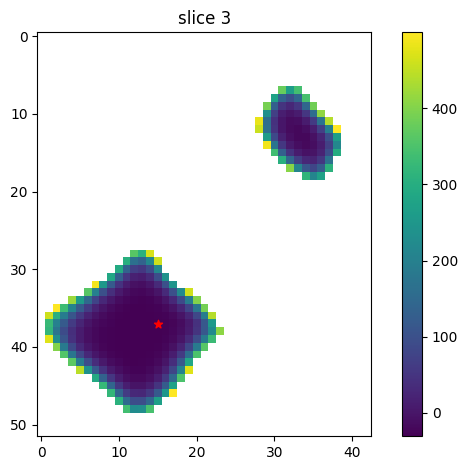

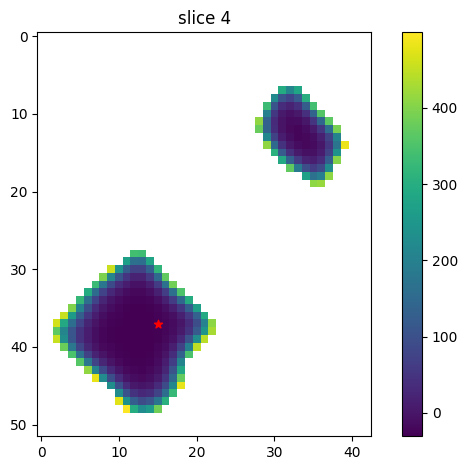

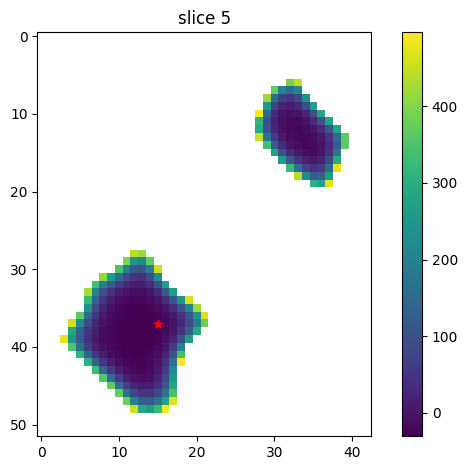

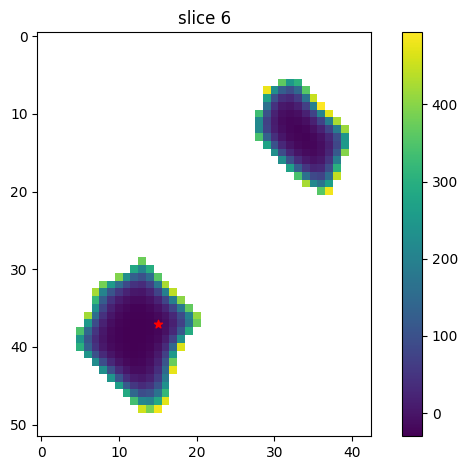

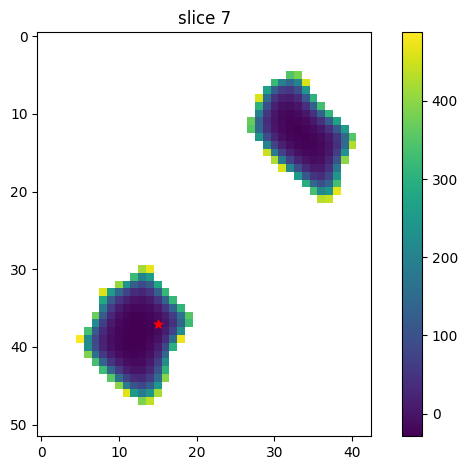

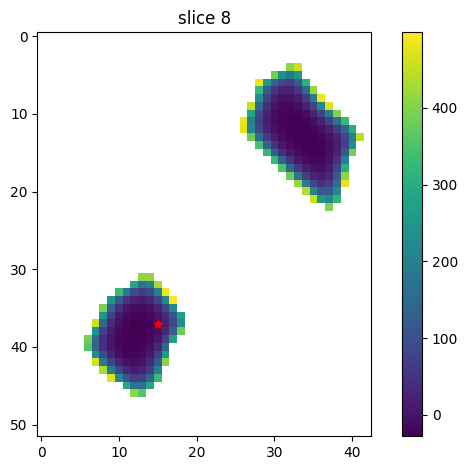

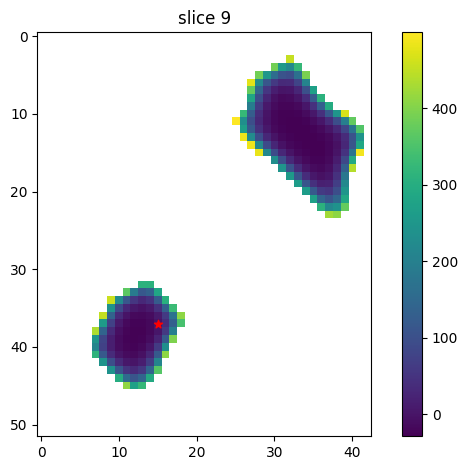

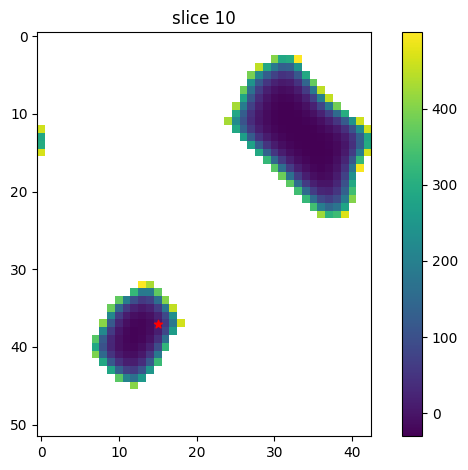

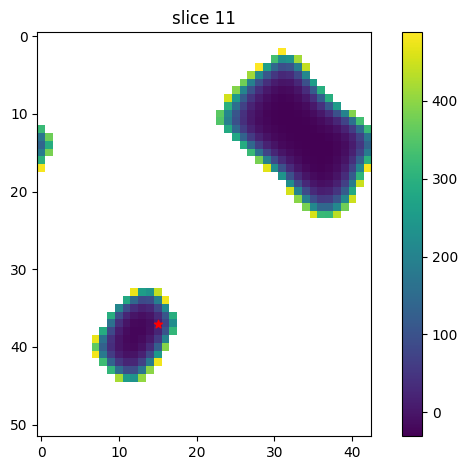

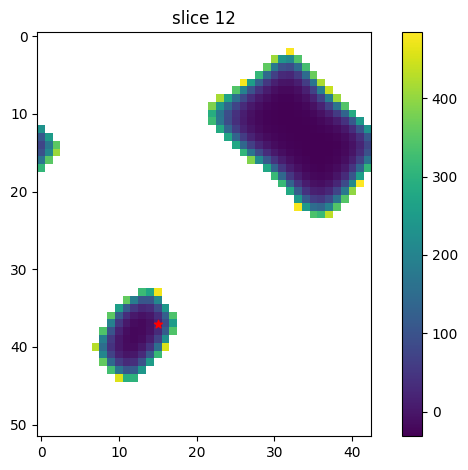

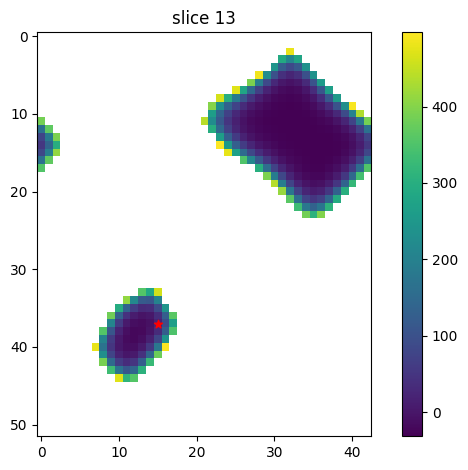

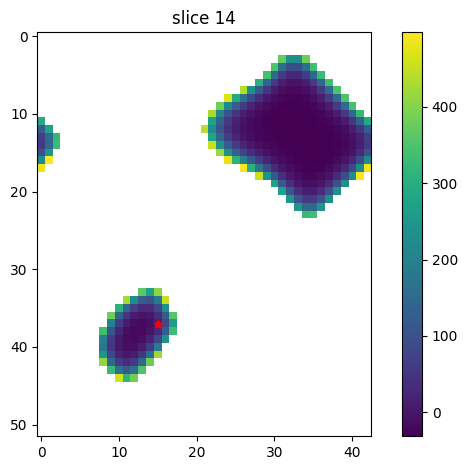

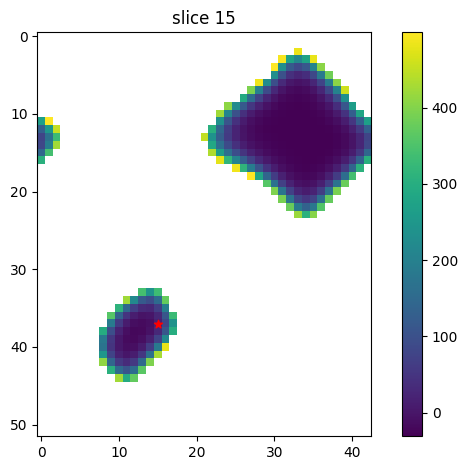

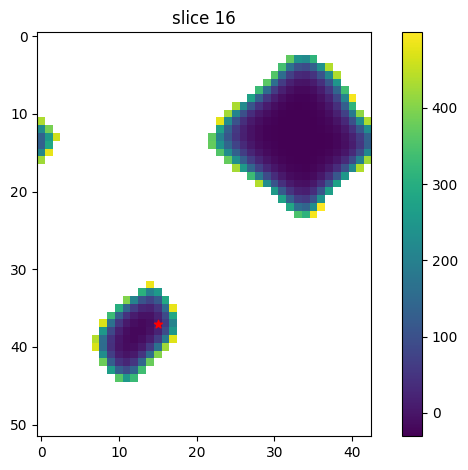

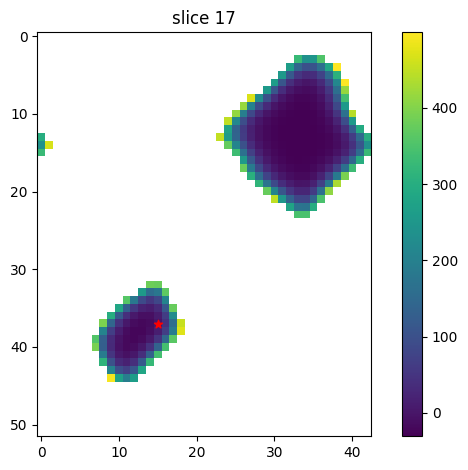

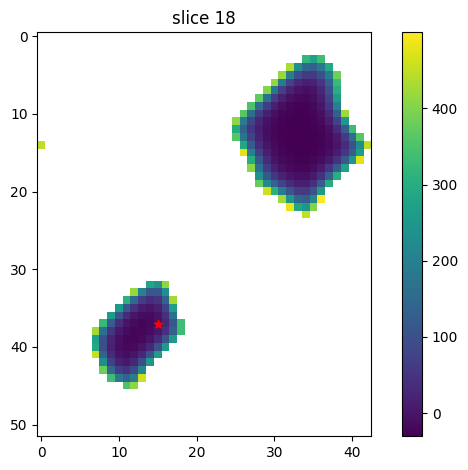

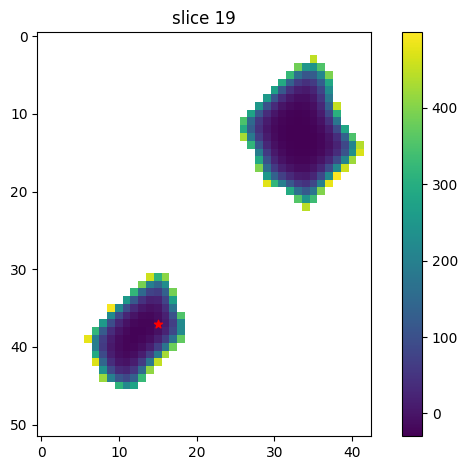

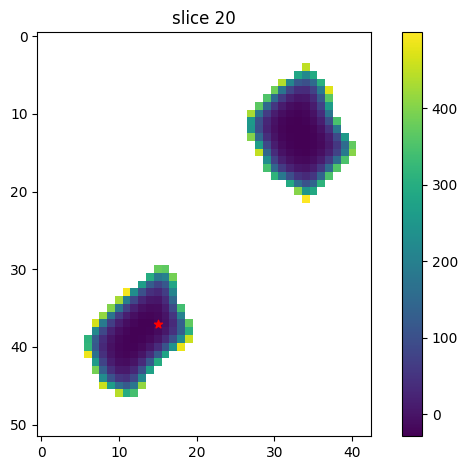

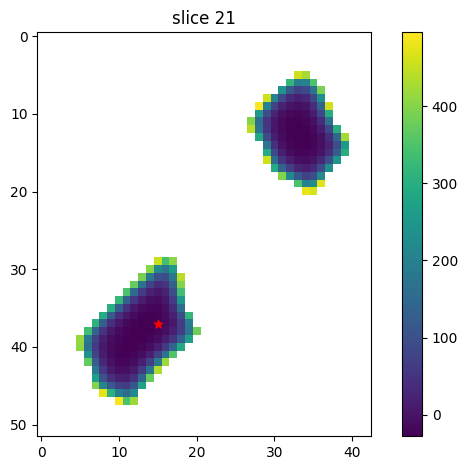

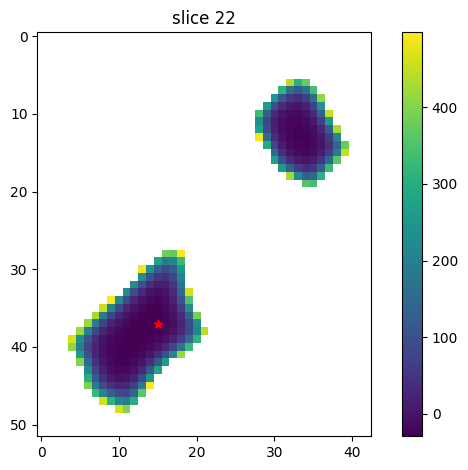

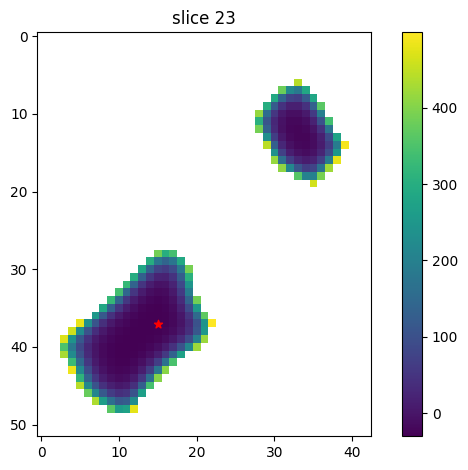

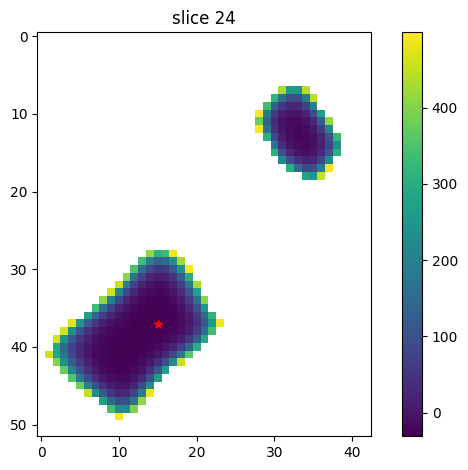

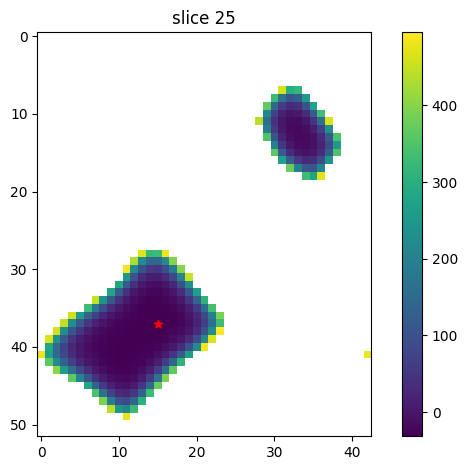

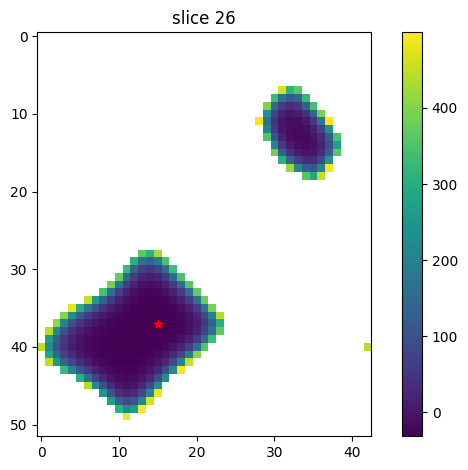

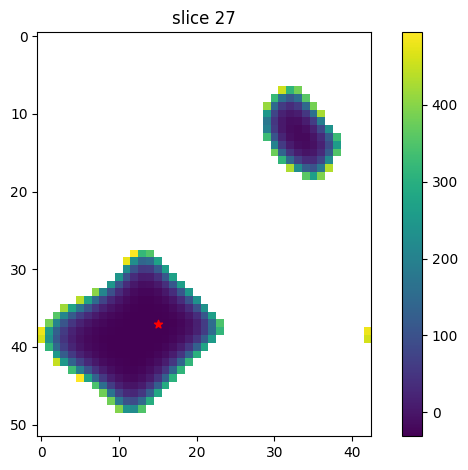

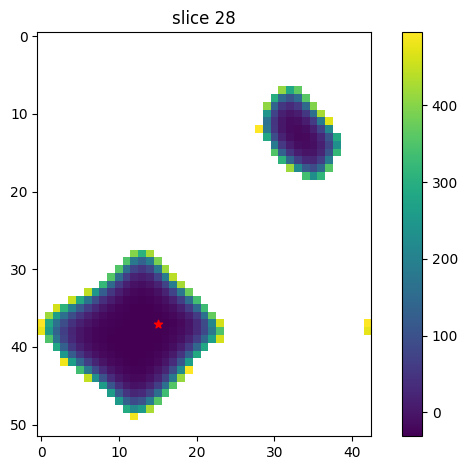

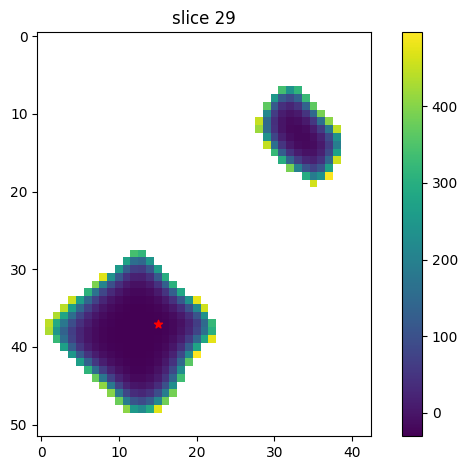

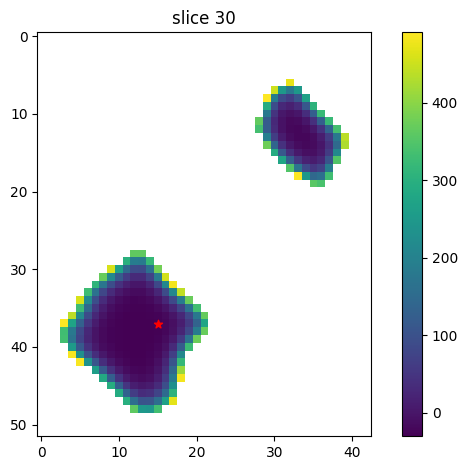

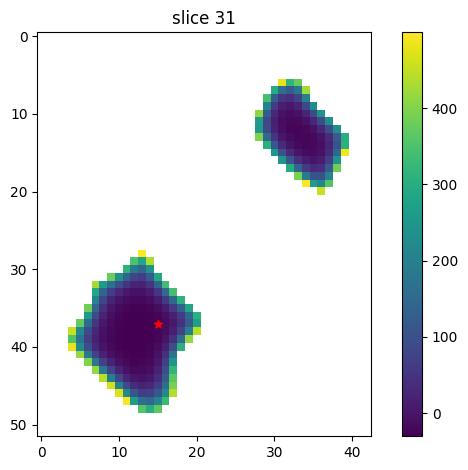

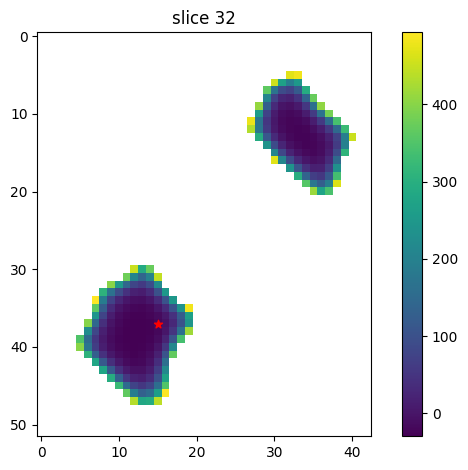

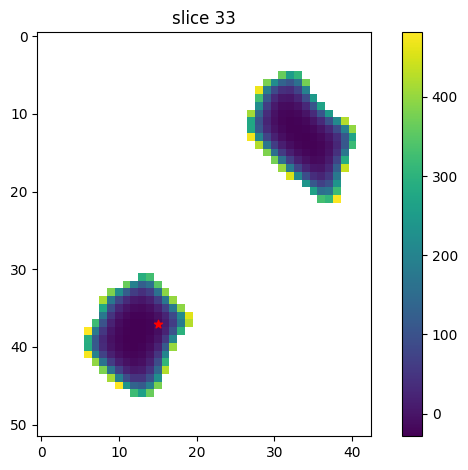

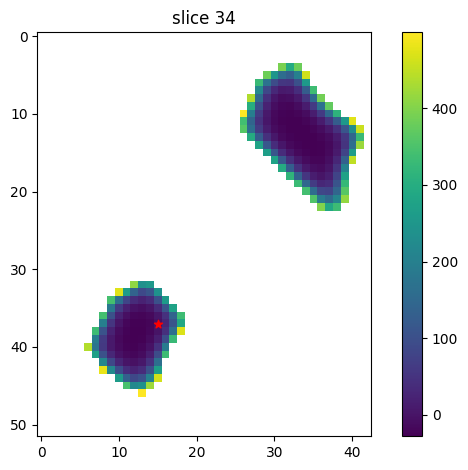

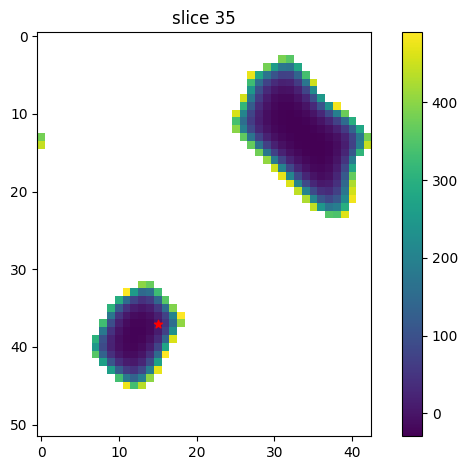

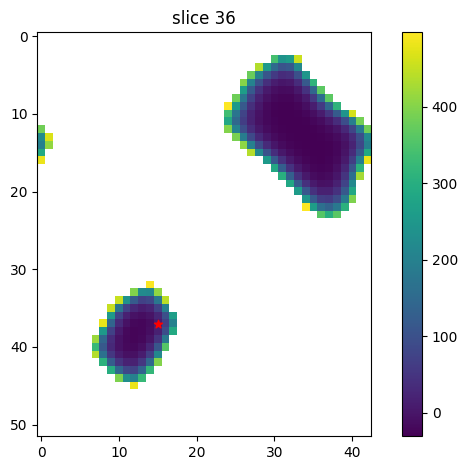

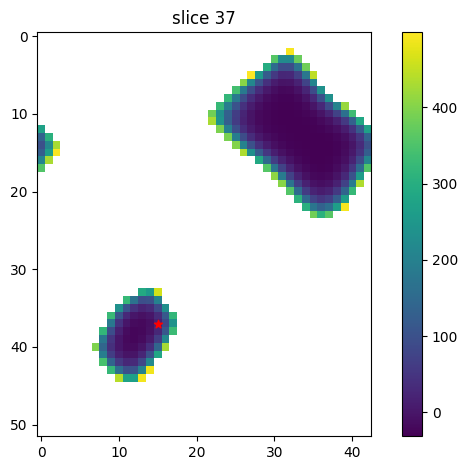

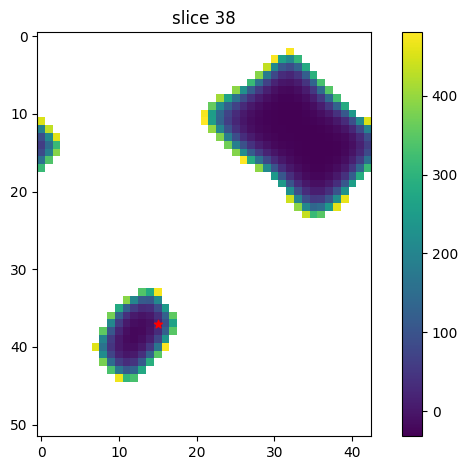

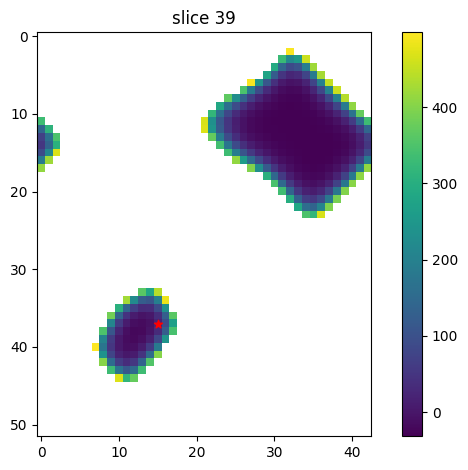

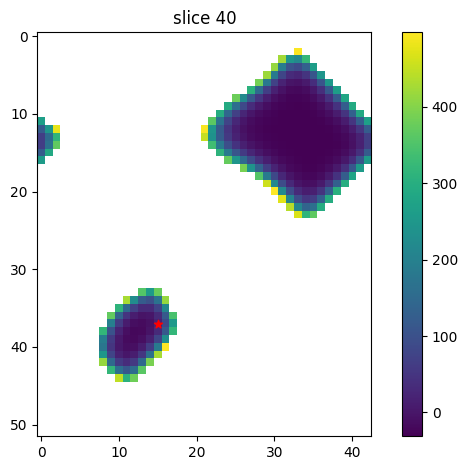

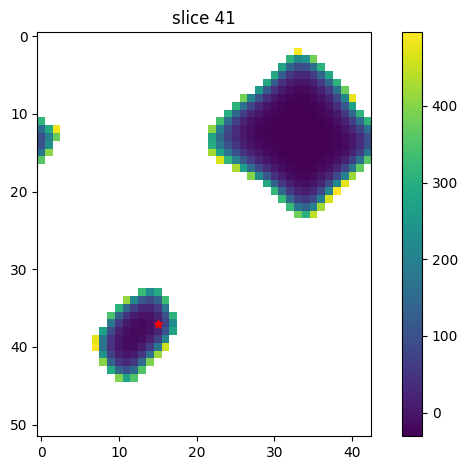

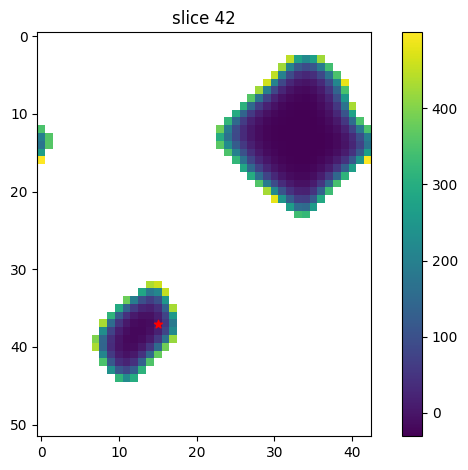

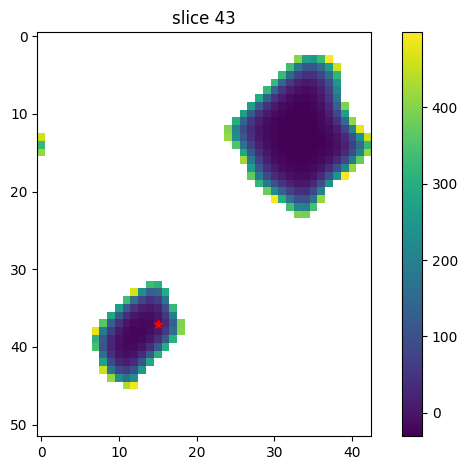

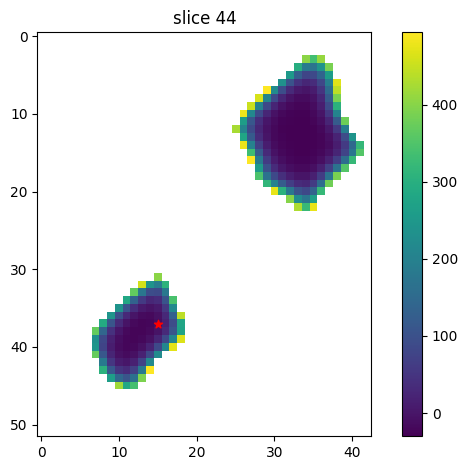

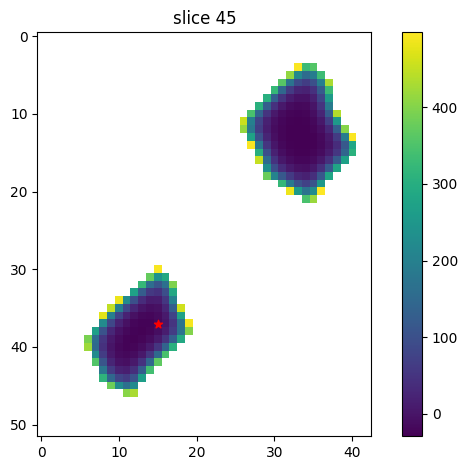

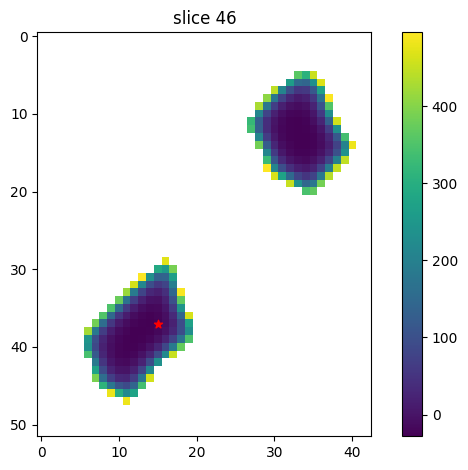

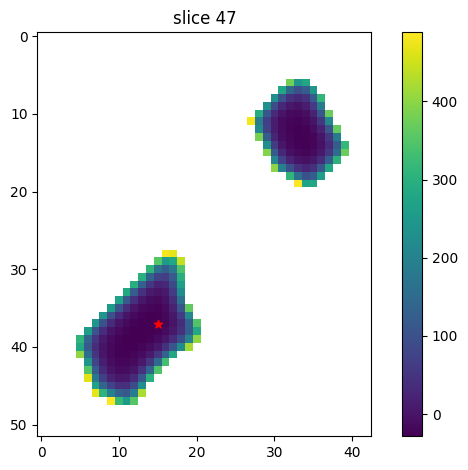

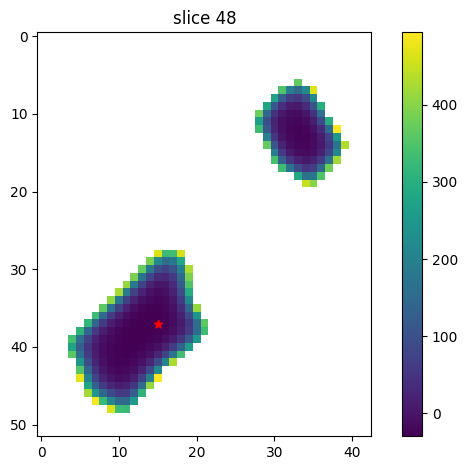

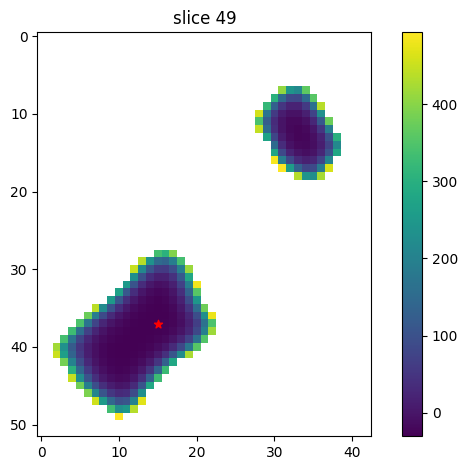

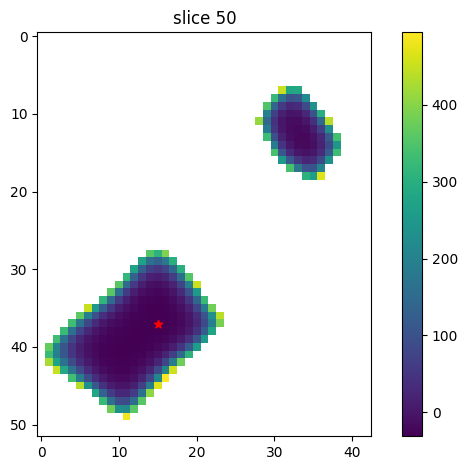

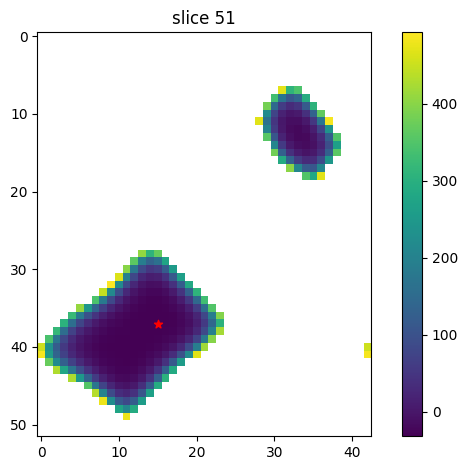

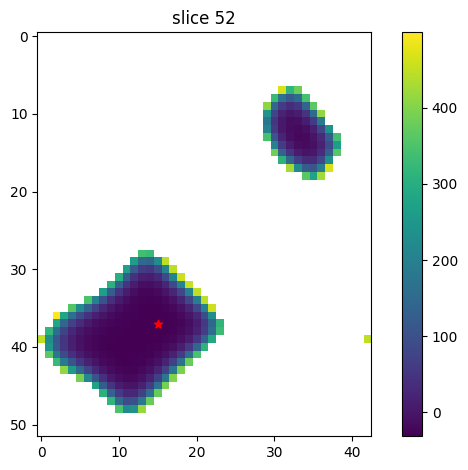

In [9]:
# TODO: Cap max vals and add colorbar... loop over the indecies to make a movie?
# helpful link: https://matplotlib.org/3.5.0/gallery/images_contours_and_fields/image_annotated_heatmap.html

for k in 1:grid.n_pts[1]
    data = deepcopy(grid.data[k, :, :])
    
    for i in 1:grid.n_pts[2]
        for j in 1:grid.n_pts[3]
            if data[i, j] > 500
                data[i, j] = Inf
            end
        end
    end
    
    # make heatmap
    fig, ax = subplots()
    ax.scatter(vox_id[2], vox_id[3], color="r", marker="*")
    ax.set_title("slice $k")
    
    im = ax.imshow(data[:, :])

    
    # Create colorbar
    cbarlabel=""
    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")
    
    fig.tight_layout()
    fig.show()
end